In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering

In [2]:
user, item, title = 'userId', 'movieId', 'title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/movie_lens_sample/ratings.csv')]

In [5]:
ratings = pd.read_csv(path/'ratings.csv')

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [7]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [8]:
y_range = [0, 5.5]

In [9]:
learn = collab_learner(data, n_factors=50, y_range=y_range, wd=1e-1)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


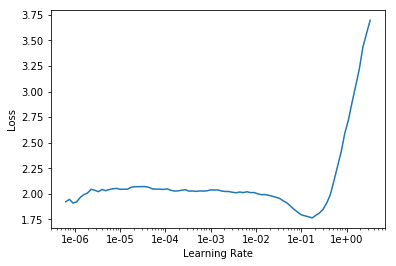

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.607366,0.954151,00:00
1,0.845900,0.686000,00:00
2,0.650621,0.673350,00:00


## Movielens 100k

In [13]:
Config.data_path()

PosixPath('/home/jupyter/.fastai/data')

In [14]:
path = Config.data_path()/'ml-100k'

In [15]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, 
                     names=[user, item, 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, 
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
len(ratings)

100000

In [18]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [19]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [20]:
data.show_batch()

userId,title,target
6,Sense and Sensibility (1995),4.0
354,"Ice Storm, The (1997)",4.0
622,Diabolique (1996),2.0
109,Forrest Gump (1994),4.0
293,City Hall (1996),2.0


In [21]:
y_range = [0, 5.5]

In [22]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


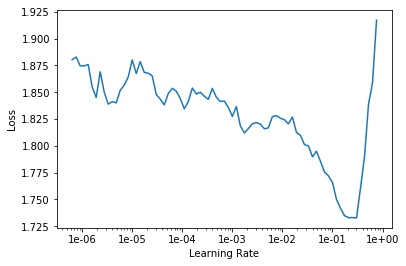

In [23]:
learn.lr_find()
learn.recorder.plot(skip_end=13)

In [24]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.954849,0.951282,00:11
1,0.880355,0.888711,00:11
2,0.783795,0.835936,00:10
3,0.640908,0.815695,00:12
4,0.567595,0.813236,00:11


In [25]:
learn.save('dotprod')

## Interpretation

In [26]:
learn.load('dotprod')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userId 498; title Casino (1995); ,userId 642; title Pocahontas (1995); ,userId 58; title 2001: A Space Odyssey (1968); ,userId 495; title Cat People (1982); ,userId 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<clas

In [27]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [28]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

## Movie bias

In [29]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [30]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i, b in zip(top_movies, movie_bias)]

In [31]:
item0 = lambda o:o[0]

In [32]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3673),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2916),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2698), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2643), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2618), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2570), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2543), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2439), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2434), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2359), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2289), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2200), 'Ready to Wear (Pret-A-Porter) (1994)', 1.8333333333333333),
 (tensor(-0.2191), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2137), 'Grease 2 (1982)', 2.0),
 (tensor(-

In [33]:
sorted(movie_ratings, key=item0, reverse=True)[:15]

[(tensor(0.5950), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5636), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5589), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5543), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5434), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5198), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5179), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5118), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5029), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4924), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4856), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4779), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4776), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4759), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4702), 'Godfather, The (1972)', 4.283292978208232)]

## Movie weight

In [34]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [35]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [36]:
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f, i) for f, i in zip(fac0, top_movies)]

In [37]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0602), 'Close Shave, A (1995)'),
 (tensor(1.0530), 'Casablanca (1942)'),
 (tensor(1.0502), 'Chinatown (1974)'),
 (tensor(1.0133), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.9558), 'When We Were Kings (1996)'),
 (tensor(0.9502), 'Persuasion (1995)'),
 (tensor(0.9451), 'Lawrence of Arabia (1962)'),
 (tensor(0.9358), 'Third Man, The (1949)'),
 (tensor(0.9334), 'Wrong Trousers, The (1993)'),
 (tensor(0.9334), 'Godfather, The (1972)')]

In [38]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3739), 'Home Alone 3 (1997)'),
 (tensor(-1.2385), "McHale's Navy (1997)"),
 (tensor(-1.2181), 'Leave It to Beaver (1997)'),
 (tensor(-1.1880), 'Congo (1995)'),
 (tensor(-1.1769), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1450), 'Jungle2Jungle (1997)'),
 (tensor(-1.0932), 'Bio-Dome (1996)'),
 (tensor(-1.0580), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0540), 'Flipper (1996)'),
 (tensor(-1.0534), 'Grease 2 (1982)')]

In [39]:
movie_comp = [(f, i) for f, i in zip(fac1, top_movies)]

In [40]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9378), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.9162), 'Keys to Tulsa (1997)'),
 (tensor(0.8495), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7810), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7787), 'Dead Man (1995)'),
 (tensor(0.7769), 'Brazil (1985)'),
 (tensor(0.7751), 'Clockwork Orange, A (1971)'),
 (tensor(0.7730), 'Trainspotting (1996)'),
 (tensor(0.7602), 'Crash (1996)'),
 (tensor(0.7334), 'Big Night (1996)')]

In [41]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1253), 'Braveheart (1995)'),
 (tensor(-1.1054), 'Titanic (1997)'),
 (tensor(-1.0488), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9202), 'American President, The (1995)'),
 (tensor(-0.9131), 'Forrest Gump (1994)'),
 (tensor(-0.8847), "It's a Wonderful Life (1946)"),
 (tensor(-0.8673), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8592), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8580), 'Pretty Woman (1990)'),
 (tensor(-0.8421), 'Independence Day (ID4) (1996)')]

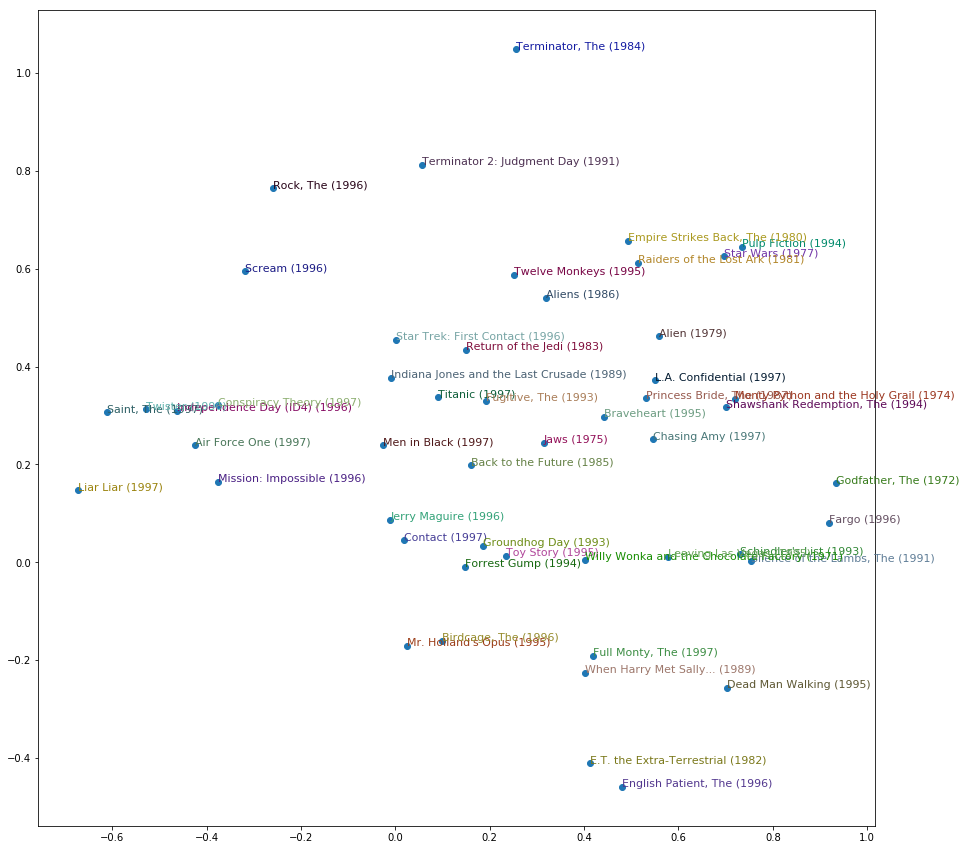

In [42]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15, 15))
plt.scatter(X, Y)

for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)

plt.show()